Note:
- La partie feature selection n'est au final pas utilisée!
- Les dictionnaires .pkl sont générés ailleurs (d'autres prétraitement)
- Il manque l'extraction de la végétation en amont.
- Il n'y a pas de gaussiennes.

## IMPORTS PACKAGES

In [1]:
import os
import configparser
import sys
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

%load_ext autoreload
%autoreload 2

# Build an absolute path from this notebook's parent directory
module_path = os.path.abspath('utils')

# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)

## IMPORT DATA

In [2]:
from data_loader import DataLoader

config = configparser.ConfigParser()
config.read('config.ini');

data_loader = DataLoader(config_path='config.ini')
data = data_loader.load()

/home/simon.walther/environments/anaconda3/envs/ml4water2/lib/python3.12/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured LineString' is converted to 'LineString'
  return ogr_read(


Loading water temperature data...
Loading air temperature data...
Loading and interpolating meteo features...
Loading upstream river network...
Extract slavi upstream features - 2013...
Extract slavi upstream features - 2014...
Extract slavi upstream features - 2015...
Extract slavi upstream features - 2016...
Extract slavi upstream features - 2017...
Extract slavi upstream features - 2018...
Extract slavi upstream features - 2019...
Extract slavi upstream features - 2020...
Extract slavi upstream features - 2021...
Extract slavi upstream features - 2022...
Extract slavi upstream features - 2023...
Extract slavi upstream features - 2024...
Loading upstream river network...
Extract dhm25 upstream features...


In [3]:
df = data['stations_data']
upstream_slavi_df = data["upstream_river_features"]["slavi"]
upstream_altitude_df = data["upstream_river_features"]["dhm25"]

In [4]:
import pandas as pd
import numpy as np

interpolated_altitudes = upstream_altitude_df.replace(0, np.nan).drop('station', axis=1).astype(float)

altitude_diff = pd.DataFrame({
    'station': upstream_altitude_df.station,
    'altitude_diff': interpolated_altitudes.mean_buffer2_distance100 - interpolated_altitudes.mean_buffer2_distance500
}).sort_values('altitude_diff').reset_index().drop('index', axis=1)

altitude_diff = {
    row['station']: row['altitude_diff'] for _, row in altitude_diff.iterrows()
}

## Train

2025-10-30 17:56:59.637334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761843419.656812 1460887 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761843419.662280 1460887 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761843419.676414 1460887 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761843419.676424 1460887 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761843419.676426 1460887 computation_placer.cc:177] computation placer alr

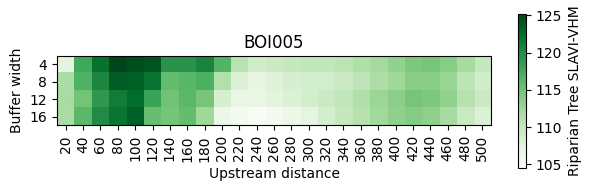

/home/simon.walther/environments/anaconda3/envs/ml4water2/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/simon.walther/environments/anaconda3/envs/ml4water2/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/simon.walther/environments/anaconda3/envs/ml4water2/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'GeoDataFrame.transpose' instead.
  return bound(*args, **kwds)
/home/simon.walther/environments/anaconda3/envs/ml4water2/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'GeoDa

Fold (1/10): 
train_df size:  169514
test_df size:  19181


W0000 00:00:1761843445.908022 1460887 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Group_temperature   │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_pressure      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_evaporation   │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_wind          │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_cloud         │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_hydrometeoro… │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_snow          │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slavi (InputLayer)  │ (None, 4, 25, 1)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slope (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_temperature_… │ (None, 7)         │          7 │ Group_temperatur… │
│ (SoftmaxAttention1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_pressure_att… │ (None, 3)         │          3 │ Group_pressure[0… │
│ (SoftmaxAttention1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_evaporation_… │ (None, 2)         │          2 │ Group_evaporatio… │
│ (SoftmaxAttention1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_wind_attenti… │ (None, 2)         │          2 │ Group_wind[0][0]  │
│ (SoftmaxAttention1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_cloud_attent… │ (None, 4)         │          4 │ Group_cloud[0][0] │
│ (SoftmaxAttention1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_hydrometeoro… │ (None, 3)         │          3 │ Group_hydrometeo… │
│ (SoftmaxAttention1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_snow_attenti… │ (None, 3)         │          3 │ Group_snow[0][0]  │
│ (SoftmaxAttention1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_1    │ (None, 4, 25, 1)  │          0 │ slavi[0][0]       │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 433 (1.69 KB)

 Trainable params: 409 (1.60 KB)

 Non-trainable params: 24 (96.00 B)

None
Epoch 1/50
5298/5298 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 6.6895 - mae: 7.3444 - mse: 82.6923 - val_loss: 1.8936 - val_mae: 2.4785 - val_mse: 10.6581
Epoch 2/50
5298/5298 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 1.8461 - mae: 2.4274 - mse: 10.1056 - val_loss: 1.6714 - val_mae: 2.2473 - val_mse: 8.8646
Epoch 3/50
5298/5298 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 1.4899 - mae: 2.0493 - mse: 7.5274 - val_loss: 1.5992 - val_mae: 2.1694 - val_mse: 8.4034
Epoch 4/50
5298/5298 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 1.3458 - mae: 1.8943 - mse: 6.5377 - val_loss: 1.5458 - val_mae: 2.1111 - val_mse: 8.0912
Epoch 5/50
5298/5298 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 1.2628 - mae: 1.8030 - mse: 6.0747 - val_loss: 1.5108 - val_mae: 2.0746 - val_mse: 7.8485
Epoch 6/50
5298/5298 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 1.1916 - mae: 1.7239 - mse: 5.6554 - val_loss: 1.4660 - val_mae: 2.0248 - val_mse: 7.6160
Epoch 7/50
5298/5298 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - loss: 1.1461 - ma

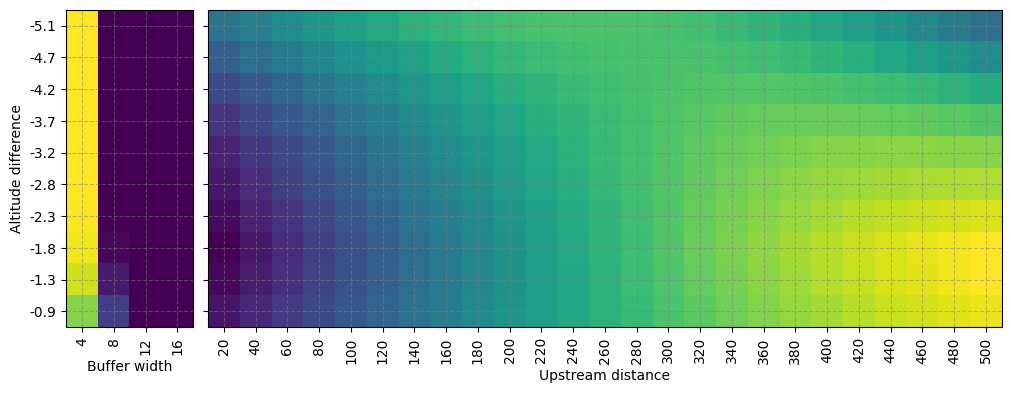

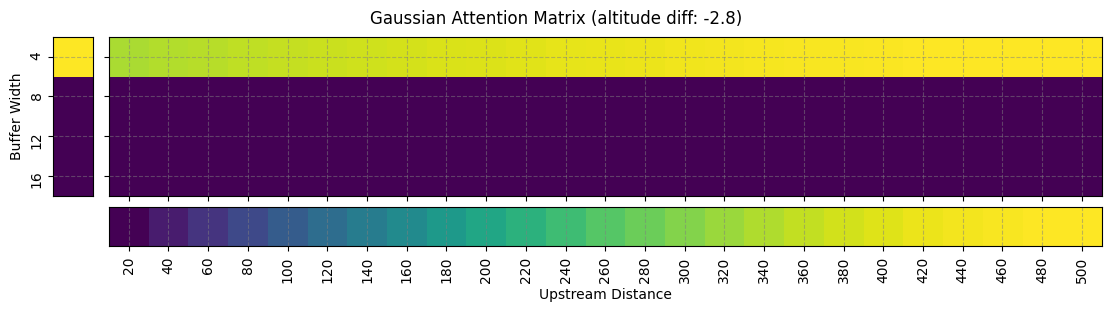

/home/simon.walther/environments/anaconda3/envs/ml4water2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


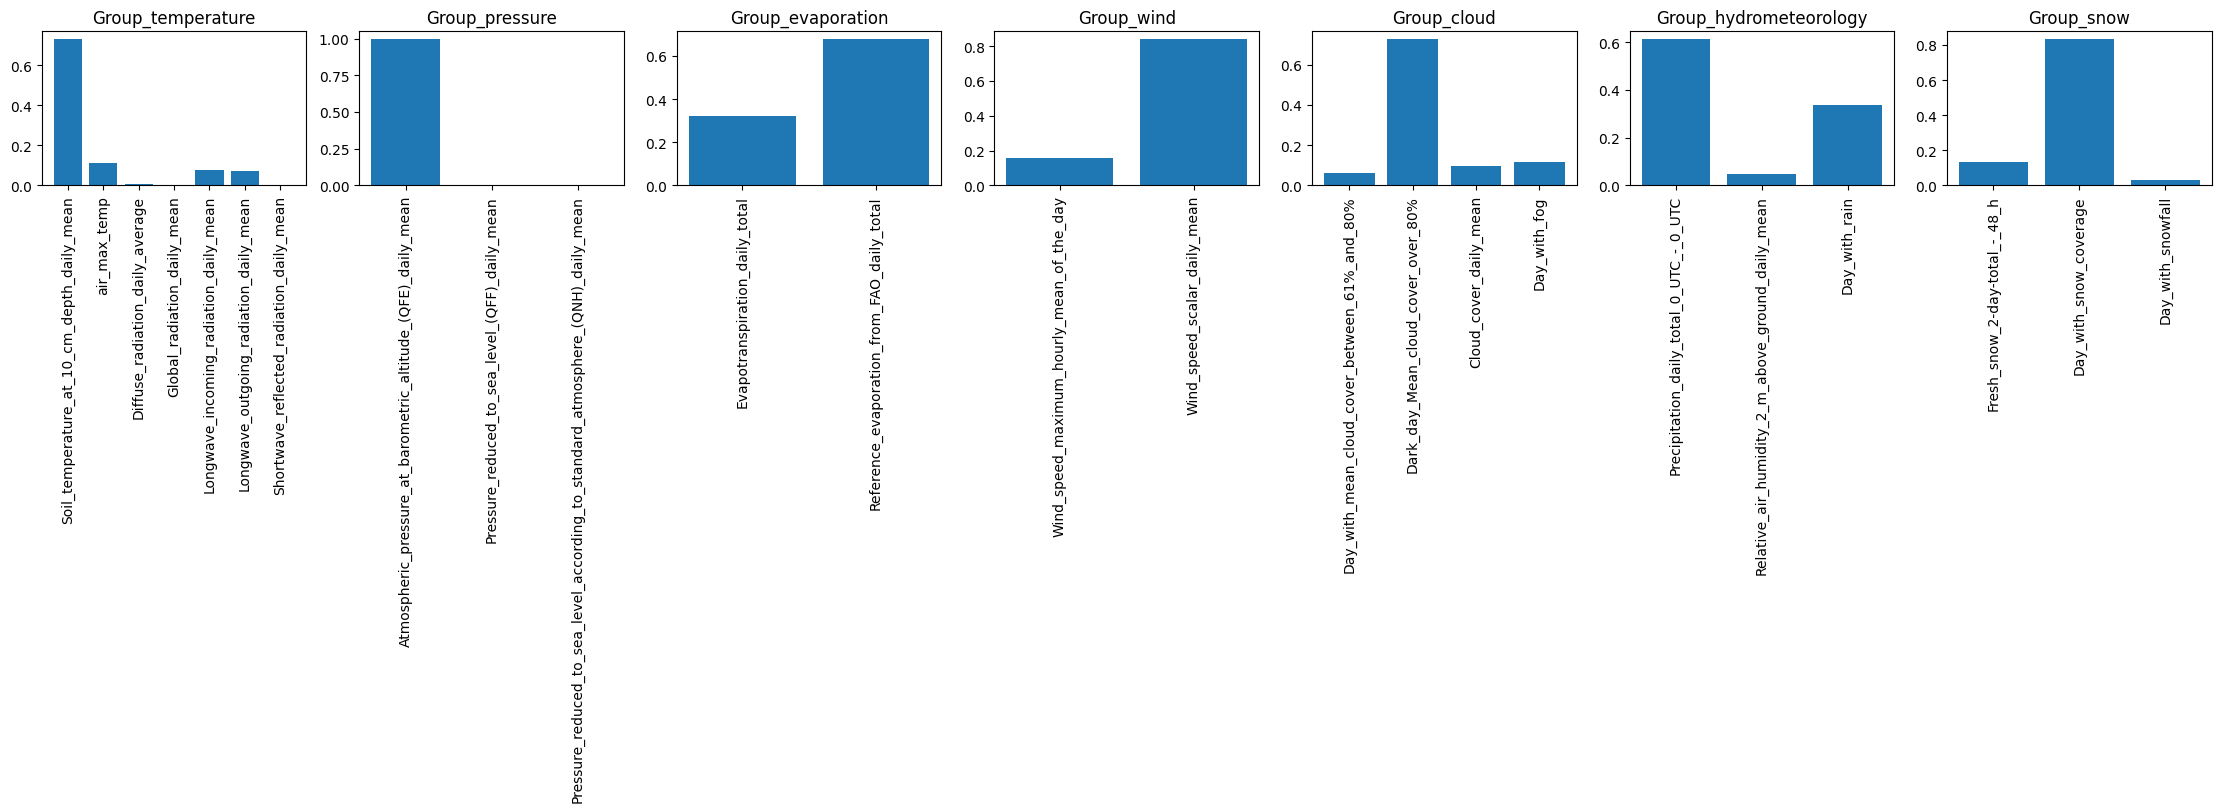

5298/5298 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - loss: 0.9241 - mae: 1.4243 - mse: 4.2034 - val_loss: 1.3024 - val_mae: 1.8380 - val_mse: 6.9324
Fold (2/10): 
train_df size:  168222
test_df size:  20473
Epoch 1/50
1361/5257 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 8.9248 - mae: 9.6062 - mse: 118.7526 

In [ ]:
from train import Training
from model import Model

model = Model(config_path='config.ini')

training = Training(df, upstream_slavi_df, altitude_diff, model, config_path='config.ini', feature_groups_config_path="feature_groups_fixed.json", save=True)
fold_models, histories = training.stations_cross_validation(n_folds=10)

## Folds MAE

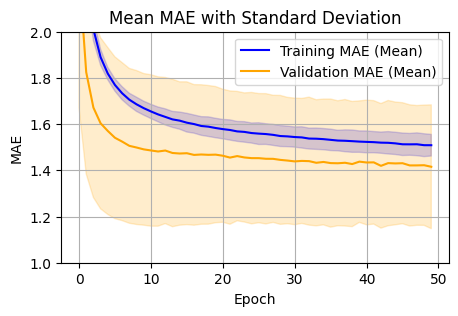

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate mean and std across all histories
mae_values = np.array([history.history['mae'] for history in histories])
val_mae_values = np.array([history.history['val_mae'] for history in histories])

# Calculate mean and std
mae_mean = np.mean(mae_values, axis=0)
mae_std = np.std(mae_values, axis=0)
val_mae_mean = np.mean(val_mae_values, axis=0)
val_mae_std = np.std(val_mae_values, axis=0)

# Plot with error bars
plt.figure(figsize=(5, 3))
plt.plot(mae_mean, color='blue', label='Training MAE (Mean)')
plt.fill_between(range(len(mae_mean)), 
                 mae_mean - mae_std, 
                 mae_mean + mae_std, 
                 color='blue', alpha=0.2)

plt.plot(val_mae_mean, color='orange', label='Validation MAE (Mean)')
plt.fill_between(range(len(val_mae_mean)), 
                 val_mae_mean - val_mae_std, 
                 val_mae_mean + val_mae_std, 
                 color='orange', alpha=0.2)

plt.ylim(1, 2)

plt.grid()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean MAE with Standard Deviation')
plt.show()

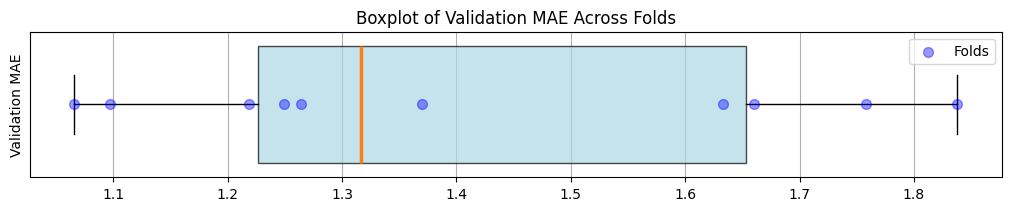

Mean MAE: 1.4154
Median MAE: 1.3169
Std MAE: 0.2680
Min MAE: 1.0655
Max MAE: 1.8380


In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Extract the last validation MAE for each fold
last_val_mae = []
for history in histories:
    # Get the last epoch's validation MAE
    last_mae = history.history['val_mae'][-1]
    last_val_mae.append(last_mae)

# Create boxplot
medianprops = dict(linewidth=2.5)

plt.figure(figsize=(10, 2), layout="constrained")
box_plot = plt.boxplot(last_val_mae, patch_artist=True, orientation="horizontal", widths=0.8, medianprops=medianprops)
plt.ylabel('Validation MAE')
plt.title('Boxplot of Validation MAE Across Folds')
plt.yticks([])

# Optional: Add some styling
box_plot['boxes'][0].set_facecolor('lightblue')
box_plot['boxes'][0].set_alpha(0.7)

# Add individual data points as scatter
plt.scatter(last_val_mae, [1] * len(last_val_mae), 
           color='blue', alpha=0.4, s=50, zorder=5, label="Folds")

plt.legend()
plt.grid()

plt.show()

# Print summary statistics
print(f"Mean MAE: {np.mean(last_val_mae):.4f}")
print(f"Median MAE: {np.median(last_val_mae):.4f}")
print(f"Std MAE: {np.std(last_val_mae):.4f}")
print(f"Min MAE: {np.min(last_val_mae):.4f}")
print(f"Max MAE: {np.max(last_val_mae):.4f}")


## Attention on all data 

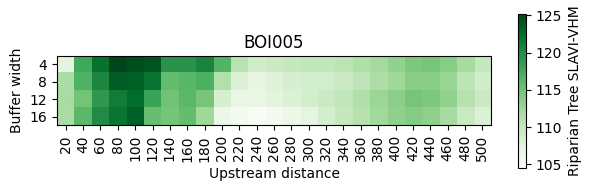

train_df size:  188695
test_df size:  188695
Epoch 1/50
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - loss: 6.0589 - mae: 6.7062 - mse: 73.1232  
Epoch 2/50
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 1.7202 - mae: 2.2916 - mse: 9.4113 
Epoch 3/50
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 1.4704 - mae: 2.0253 - mse: 7.6004
Epoch 4/50
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 1.3710 - mae: 1.9177 - mse: 6.9231
Epoch 5/50
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 1.3073 - mae: 1.8491 - mse: 6.4875
Epoch 6/50
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 1.2628 - mae: 1.7999 - mse: 6.2341
Epoch 7/50
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 1.2275 - mae: 1.7622 - mse: 5.9755
Epoch 8/50
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 1.2005 - mae: 1.7324 - mse: 5.8126
Epoch 9/50
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 1.1763 - mae: 1.7061 - mse: 5.6776
Epoch 10/50
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 1.154

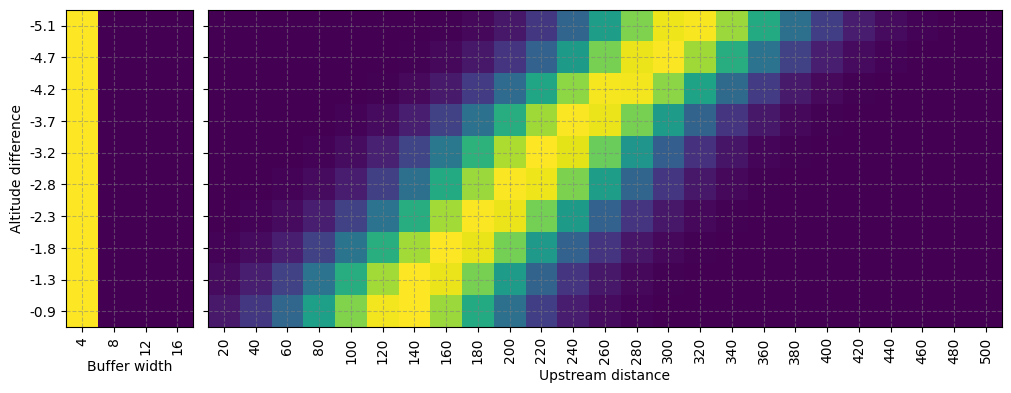

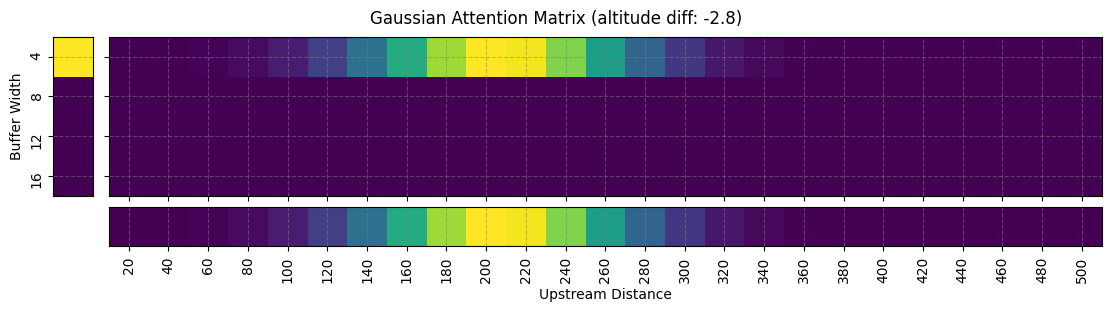

/home/simon.walther/environments/anaconda3/envs/ml4water2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


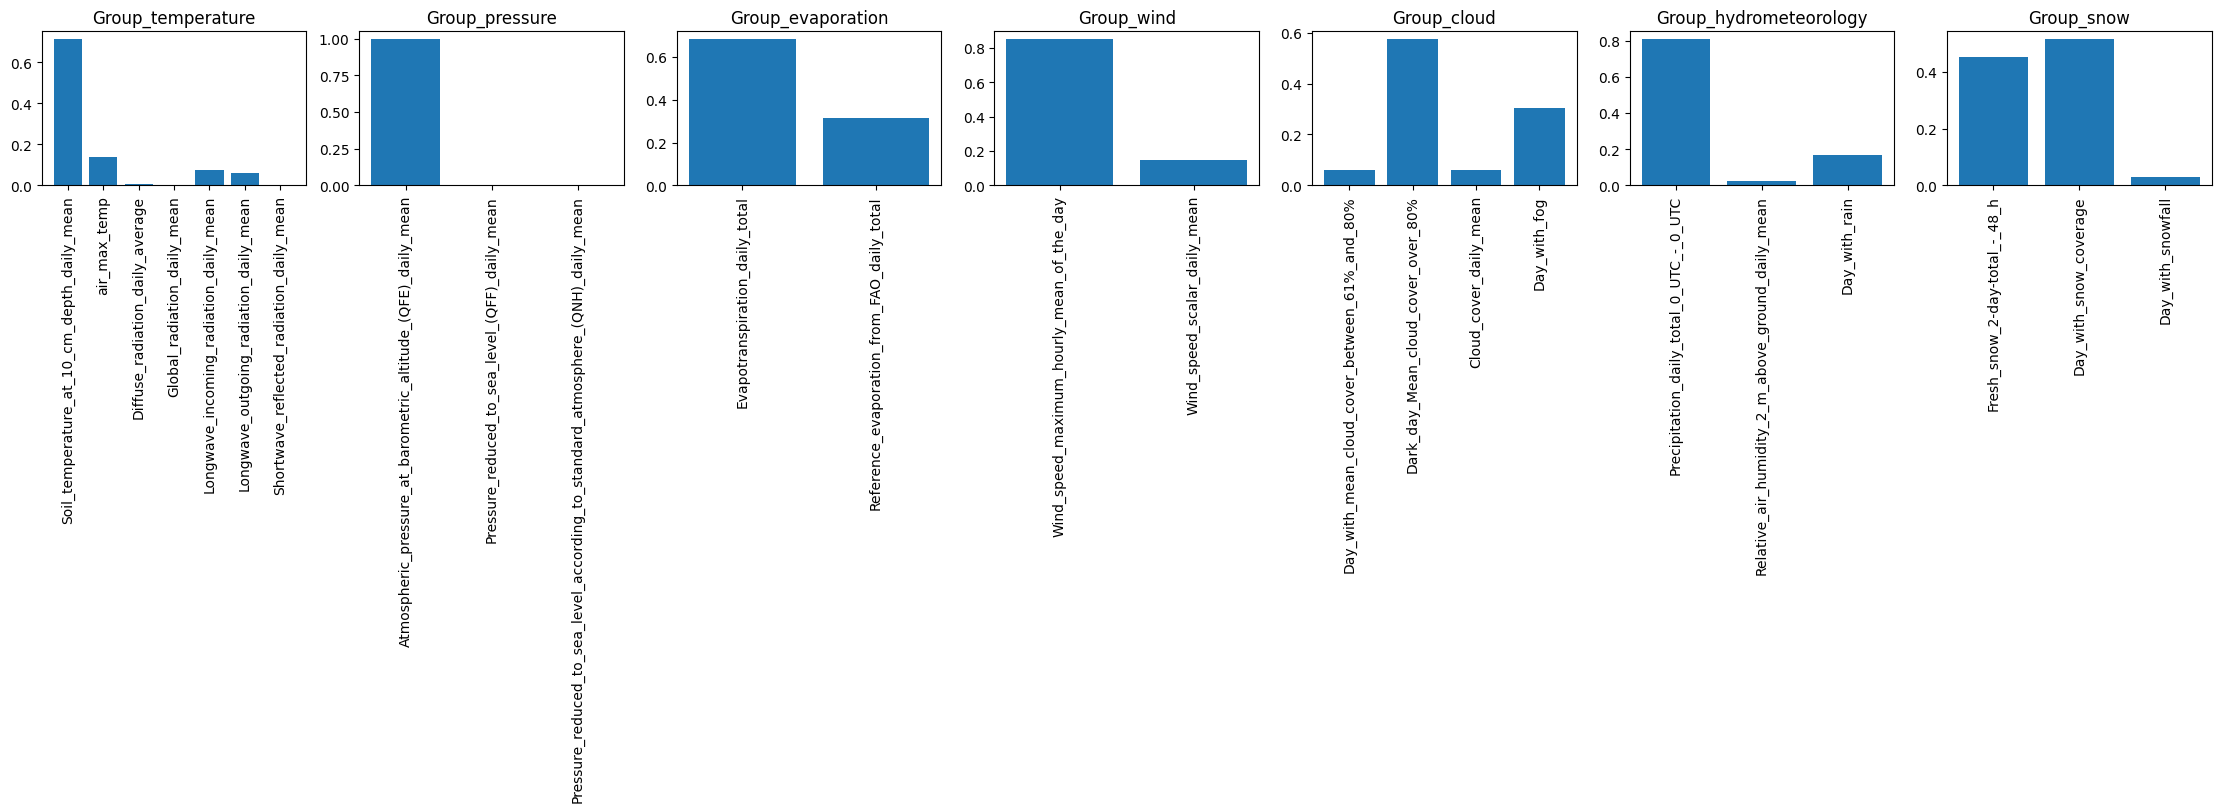

5897/5897 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 1.0022 - mae: 1.5100 - mse: 4.7254


In [14]:
from train import Training
from model import Model

model = Model(config_path='config.ini')

training = Training(df, upstream_slavi_df, altitude_diff, model, config_path='config.ini', feature_groups_config_path="feature_groups_fixed.json", save=True)
model, train_inputs, history = training.train_model_on_all_data()

In [18]:
shap_values, explainer = training.report_explainable_metrics(model, train_inputs, config_path='config.ini')

first half model output shape:  12


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Group_temperature   │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_pressure      │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_evaporation   │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_wind          │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_cloud         │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_hydrometeoro… │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_snow          │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slavi (InputLayer)  │ (None, 4, 25, 1)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slope (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_temperature_… │ (None, 7)         │          7 │ Group_temperatur… │
│ (SoftmaxAttention1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_pressure_att… │ (None, 3)         │          3 │ Group_pressure[0… │
│ (SoftmaxAttention1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_evaporation_… │ (None, 2)         │          2 │ Group_evaporatio… │
│ (SoftmaxAttention1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_wind_attenti… │ (None, 2)         │          2 │ Group_wind[0][0]  │
│ (SoftmaxAttention1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_cloud_attent… │ (None, 4)         │          4 │ Group_cloud[0][0] │
│ (SoftmaxAttention1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_hydrometeoro… │ (None, 3)         │          3 │ Group_hydrometeo… │
│ (SoftmaxAttention1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Group_snow_attenti… │ (None, 3)         │          3 │ Group_snow[0][0]  │
│ (SoftmaxAttention1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise_23   │ (None, 4, 25, 1)  │          0 │ slavi[0][0]       │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 32 (128.00 B)

 Trainable params: 32 (128.00 B)

 Non-trainable params: 0 (0.00 B)

first model:  None


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_11          │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 16)             │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401 (1.57 KB)

 Trainable params: 377 (1.47 KB)

 Non-trainable params: 24 (96.00 B)

second model:  None
5897/5897 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
predicted_features shape:  (188695, 12)
background shape:  [[ 2.2157423e-01  2.2694497e-01  9.5419180e-01 ... -1.2449549e+00
  -6.9379938e-01  4.4146441e-03]
 [ 1.9190037e-01  1.3319083e-01  8.4448166e-02 ... -1.2770042e+00
  -6.2842411e-01  2.7744498e-04]
 [-3.4609847e-02 -2.7834746e-01 -3.4343127e-02 ... -2.4299322e-01
   1.3500413e+00  1.3046235e-02]
 ...
 [-2.2922793e-01 -2.2134475e-01 -4.5211264e-01 ...  1.3602545e+00
   3.8946712e-01  7.6163434e-03]
 [ 1.8146190e-01 -1.3376833e-01  4.7435659e-01 ... -1.4021231e+00
  -1.3729951e-01 -6.5618963e-04]
 [ 3.1848282e-02  1.2596473e-01  5.5272944e-02 ... -2.6687628e-01
  -1.4261440e+00 -6.4842422e-03]]
['Group_temperature', 'Group_pressure', 'Group_evaporation', 'Group_wind', 'Group_cloud', 'Group_hydrometeorology', 'Group_snow', 'slavi', 'slope', 'input_other']
['Group_temperature' 'Group_pressure' 'Group_evaporation' 'Group_wind'
 'Group_cloud' 'Group_hydrometeorology' 'Gro

PermutationExplainer explainer: 47174it [1:43:45,  7.57it/s]                                                                                                                        


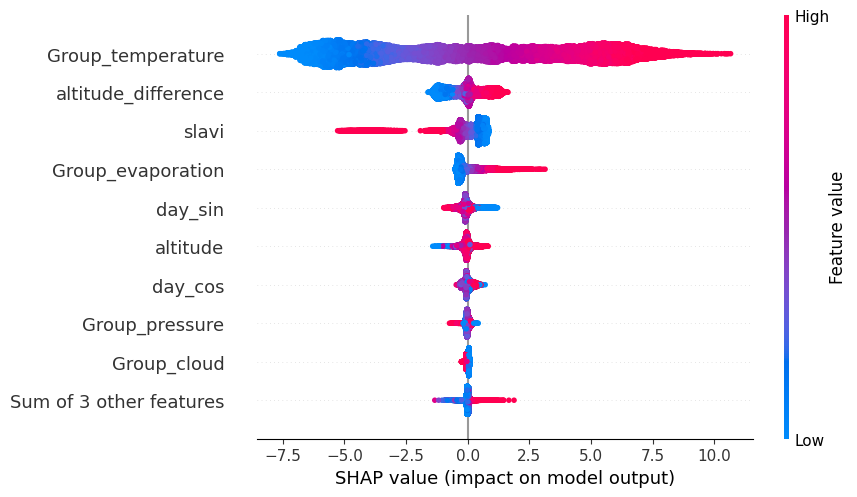

<Figure size 640x480 with 0 Axes>

In [45]:
import shap

shap.initjs()

shap.plots.beeswarm(shap_values)

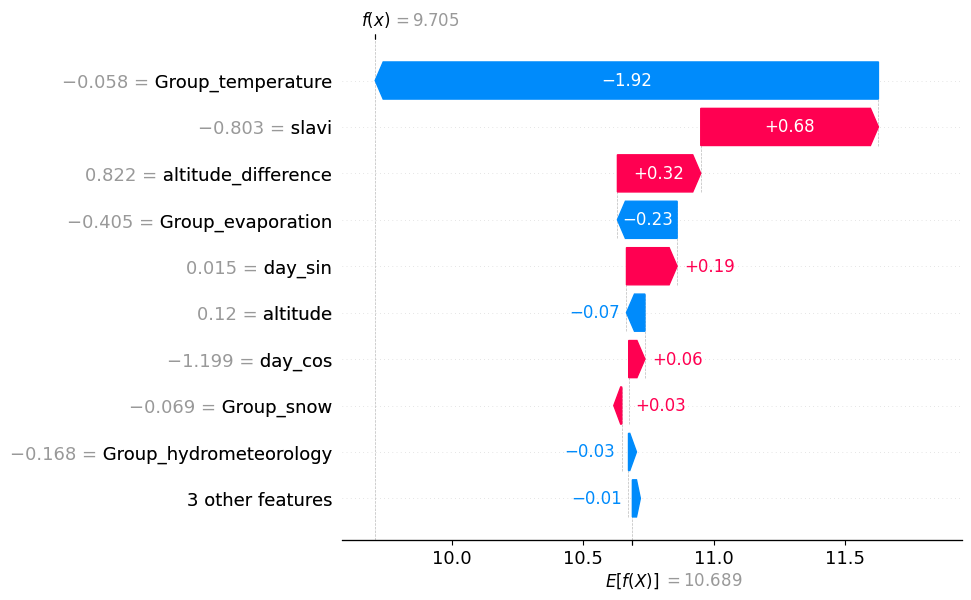

In [20]:
shap.plots.waterfall(shap_values[3])

0


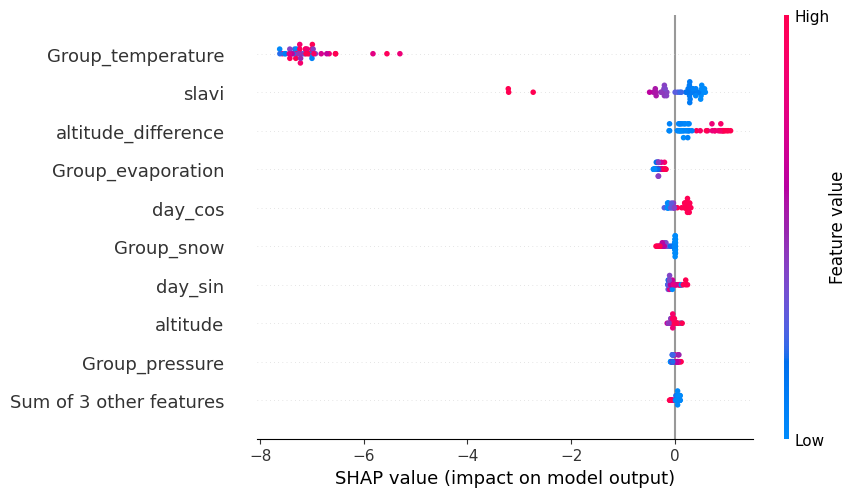

In [25]:

feature_name = "Group_temperature"

col_idx = shap_values.feature_names.index(feature_name)
print(col_idx)

percentile = 0.1
threshold = np.percentile(shap_values.data[:, col_idx], percentile)

# filtered_shap_high = shap_values[shap_values.data[:, col_idx] >= threshold]

filtered_shap_low = shap_values[shap_values.data[:, col_idx] <= threshold]

shap.plots.beeswarm(filtered_shap_low)




In [26]:
feature_names=shap_values.feature_names

# Choose your two features
evap_idx = feature_names.index("slavi")
temp_idx = feature_names.index("Group_temperature")

# Extract their SHAP values
shap_evap = shap_values.values[:, evap_idx]
shap_temp = shap_values.values[:, temp_idx]

# Correlation between contributions
interaction_corr = np.corrcoef(shap_evap, shap_temp)[0, 1]
print(f"Correlation between SHAP contributions = {interaction_corr:.3f}")


Correlation between SHAP contributions = -0.006


In [27]:
print(shap_values.values.shape)

(47173, 12)


In [24]:
import shap

# Map feature names to column indices
slavi_idx = shap_values.feature_names.index("slavi")
temp_idx = shap_values.feature_names.index("Group_temperature")

# Scatter plot using integer indexing
shap.plots.scatter(
    shap_values[:, slavi_idx],          # index feature by integer
    color=shap_values[:, temp_idx]      # color by another feature
)


IndexError: index 7 is out of bounds for axis 1 with size 1

In [ ]:
type(shap_values.values)

# profile analysis

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model, Sequential, layers

def analyze_neuron_effect(
    ann_model,
    train_inputs,
    feature_groups,
    feature_name,
    point_idx=0,
    n_points=100,
):
    """
    Splits the ANN at 'concatenated_inputs', computes intermediate activations,
    and varies one neuron (specified by feature name) to visualize
    its effect on the final model output.

    Parameters
    ----------
    ann_model : keras.Model
        The full ANN model.
    train_inputs : list or np.ndarray
        Input data (as used for training).
    feature_groups : object
        Object containing `.groups` dictionary with "input_other" feature names.
    feature_name : str
        Name of the neuron to vary (must exist in the concatenated feature list).
    point_idx : int, optional
        Index of the sample to fix as base.
    n_points : int, optional
        Number of points to evaluate between min and max.

    Returns
    -------
    dict
        Contains first_half_model, second_half_model, predicted_features,
        outputs, neuron_values, and feature_names.
    """

    # ─── Find split point ─────────────────────────────────────────────
    for idx, layer in enumerate(ann_model.layers):
        if layer.name == "concatenated_inputs":
            break

    # First half (up to concatenated layer)
    first_half = ann_model.layers[: (idx + 1)]
    first_half_inputs = [
        layer.output for layer in first_half if layer.__class__.__name__ == "InputLayer"
    ]
    first_half_output = first_half[-1].output
    first_half_model = Model(inputs=first_half_inputs, outputs=first_half_output)

    # Second half (from concatenated layer onward)
    second_half_input = layers.Input((first_half_model.output_shape[-1],))
    second_half_model = Sequential([second_half_input] + ann_model.layers[(idx + 1) :])

    print(f"Split model at layer {ann_model.layers[idx].name}")
    print(f"→ first_half_model output shape: {first_half_model.output_shape}")
    print(f"→ second_half_model input shape: {second_half_model.input_shape}")

    # ─── Compute intermediate activations ─────────────────────────────
    predicted_features = first_half_model.predict(train_inputs, verbose=0)
    predicted_features = np.array(predicted_features)
    print(f"predicted_features shape: {predicted_features.shape}")

    # ─── Build feature names (same as in your report_explainable_metrics) ──────────
    feature_names = np.concatenate(
        [
            (
                layer.name
                if layer.name != "input_other"
                else feature_groups.groups["input_other"]
            )
            for layer in first_half
            if layer.__class__.__name__ == "InputLayer" and layer.name != "slope"
        ],
        axis=None,
    )

    print(f"feature_names ({len(feature_names)}):")
    print(feature_names)

    # ─── Determine neuron index ───────────────────────────────────────
    if feature_name not in feature_names:
        raise ValueError(f"Feature name '{feature_name}' not found in feature_names.")
    neuron_idx = np.where(feature_names == feature_name)[0][0]
    feature_label = feature_names[neuron_idx]

    # ─── Choose base sample ───────────────────────────────────────────
    base_input = predicted_features[point_idx].copy()

    # ─── Determine neuron range ───────────────────────────────────────
    neuron_min = np.min(predicted_features[:, neuron_idx])
    neuron_max = np.max(predicted_features[:, neuron_idx])
    neuron_values = np.linspace(neuron_min, neuron_max, n_points)

    # ─── Create modified inputs ───────────────────────────────────────
    varied_inputs = np.tile(base_input, (n_points, 1))
    varied_inputs[:, neuron_idx] = neuron_values

    # ─── Predict through second half ──────────────────────────────────
    outputs = second_half_model.predict(varied_inputs, verbose=0)

    # ─── Plot results ─────────────────────────────────────────────────
    plt.figure(figsize=(7, 5))
    if outputs.ndim > 1 and outputs.shape[1] > 1:
        for j in range(outputs.shape[1]):
            plt.plot(neuron_values, outputs[:, j], label=f"Output neuron {j}")
    else:
        plt.plot(neuron_values, outputs, label="Model output")
    plt.xlabel(f"Feature '{feature_label}' value (concatenated layer output)")
    plt.ylabel("Model output")
    plt.title(f"Sensitivity of model output to feature '{feature_label}'")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        "first_half_model": first_half_model,
        "second_half_model": second_half_model,
        "predicted_features": predicted_features,
        "outputs": outputs,
        "neuron_values": neuron_values,
        "feature_names": feature_names,
        "varied_feature": feature_label,
    }


In [29]:
training.feature_groups

Split model at layer concatenated_inputs
→ first_half_model output shape: (None, 12)
→ second_half_model input shape: (None, 12)
predicted_features shape: (188695, 12)
feature_names (12):
['Group_temperature' 'Group_pressure' 'Group_evaporation' 'Group_wind'
 'Group_cloud' 'Group_hydrometeorology' 'Group_snow' 'slavi' 'altitude'
 'altitude_difference' 'day_cos' 'day_sin']


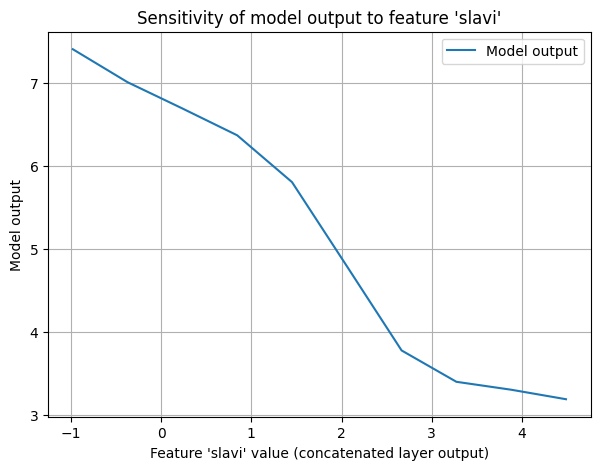

In [30]:
results = analyze_neuron_effect(
    model,
    train_inputs,
    feature_groups=training.feature_groups,
    feature_name="slavi", 
    point_idx=0,     # base sample
    n_points=10
)

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model, Sequential, layers
from matplotlib.ticker import MultipleLocator

def analyze_neuron_effect_all(
    ann_model,
    train_inputs,
    feature_groups,
    feature_name,
    n_points=100,
    max_samples=None,
):
    """
    Splits the ANN at 'concatenated_inputs', computes intermediate activations,
    and varies one neuron (specified by feature name) across all datapoints.
    Plots the mean ± std of the resulting outputs.

    Parameters
    ----------
    ann_model : keras.Model
        The full ANN model.
    train_inputs : list or np.ndarray
        Input data (as used for training).
    feature_groups : object
        Object containing `.groups` dictionary with "input_other" feature names.
    feature_name : str
        Name of the neuron to vary (must exist in the concatenated feature list).
    n_points : int, optional
        Number of points to evaluate between min and max.
    max_samples : int, optional
        Limit number of datapoints to use (for speed).

    Returns
    -------
    dict
        Contains first_half_model, second_half_model, predicted_features,
        mean_outputs, std_outputs, neuron_values, and feature_names.
    """

    # ─── Find split point ─────────────────────────────────────────────
    for idx, layer in enumerate(ann_model.layers):
        if layer.name == "concatenated_inputs":
            break

    # First half (up to concatenated layer)
    first_half = ann_model.layers[: (idx + 1)]
    first_half_inputs = [
        layer.output for layer in first_half if layer.__class__.__name__ == "InputLayer"
    ]
    first_half_output = first_half[-1].output
    first_half_model = Model(inputs=first_half_inputs, outputs=first_half_output)

    # Second half (from concatenated layer onward)
    second_half_input = layers.Input((first_half_model.output_shape[-1],))
    second_half_model = Sequential([second_half_input] + ann_model.layers[(idx + 1) :])

    print(f"Split model at layer {ann_model.layers[idx].name}")
    print(f"→ first_half_model output shape: {first_half_model.output_shape}")
    print(f"→ second_half_model input shape: {second_half_model.input_shape}")

    # ─── Compute intermediate activations ─────────────────────────────
    predicted_features = first_half_model.predict(train_inputs, verbose=0)
    predicted_features = np.array(predicted_features)
    print(f"predicted_features shape: {predicted_features.shape}")

    if max_samples is not None and predicted_features.shape[0] > max_samples:
        print(f"Subsampling {max_samples} / {predicted_features.shape[0]} datapoints")
        idxs = np.random.choice(predicted_features.shape[0], max_samples, replace=False)
        predicted_features = predicted_features[idxs]

    # ─── Build feature names ──────────────────────────────────────────
    feature_names = np.concatenate(
        [
            (
                layer.name
                if layer.name != "input_other"
                else feature_groups.groups["input_other"]
            )
            for layer in first_half
            if layer.__class__.__name__ == "InputLayer" and layer.name != "slope"
        ],
        axis=None,
    )

    if feature_name not in feature_names:
        raise ValueError(f"Feature name '{feature_name}' not found in feature_names.")
    neuron_idx = np.where(feature_names == feature_name)[0][0]
    feature_label = feature_names[neuron_idx]
    print(f"Analyzing feature '{feature_label}' (index {neuron_idx})")

    # ─── Define range for this neuron ─────────────────────────────────
    neuron_min = np.min(predicted_features[:, neuron_idx])
    neuron_max = np.max(predicted_features[:, neuron_idx])
    neuron_values = np.linspace(neuron_min, neuron_max, n_points)

    # ─── For each neuron value, evaluate all samples ──────────────────
    all_outputs = []
    for val in neuron_values:
        modified = predicted_features.copy()
        modified[:, neuron_idx] = val
        preds = second_half_model.predict(modified, verbose=0)
        preds = np.squeeze(preds)
        all_outputs.append(preds)

    all_outputs = np.array(all_outputs)  # shape: (n_points, n_samples)
    mean_outputs = all_outputs.mean(axis=1)
    std_outputs = all_outputs.std(axis=1)

    # ─── Plot mean ± std ──────────────────────────────────────────────
    plt.figure(figsize=(10, 4))
    plt.plot(neuron_values, mean_outputs, label="Mean")
    plt.fill_between(
        neuron_values,
        mean_outputs - std_outputs,
        mean_outputs + std_outputs,
        alpha=0.3,
        label="±1 std",
    )
    plt.xlabel(f"Riparian Vegation")
    plt.ylabel("Predicted Water Temperature")
    plt.gca().xaxis.set_major_locator(MultipleLocator(1))
    plt.gca().yaxis.set_major_locator(MultipleLocator(1))
    plt.title(f"Average sensitivity of model output to riparian vegetation")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        "first_half_model": first_half_model,
        "second_half_model": second_half_model,
        "predicted_features": predicted_features,
        "mean_outputs": mean_outputs,
        "std_outputs": std_outputs,
        "neuron_values": neuron_values,
        "feature_names": feature_names,
        "varied_feature": feature_label,
    }


In [32]:
import numpy as np

def filter_train_inputs_by_temperature(train_inputs, percentile_range=(0, 100)):
    """
    Filters train_inputs to only include samples whose average Group_temperature
    is within the given percentile range.

    Parameters
    ----------
    train_inputs : dict of np.ndarray
        Input data dictionary (must contain 'Group_temperature').
    percentile_range : tuple (low, high)
        Percentile range (e.g., (90, 100) for top 10%).

    Returns
    -------
    filtered_inputs : dict
        Same structure as train_inputs, but filtered along the sample dimension.
    mask : np.ndarray (bool)
        Boolean array of kept samples.
    """

    if "Group_temperature" not in train_inputs:
        raise KeyError("train_inputs must contain 'Group_temperature'")

    temp_data = train_inputs["Group_temperature"]
    temp_mean = np.mean(temp_data, axis=1)

    low_p, high_p = np.percentile(temp_mean, percentile_range)
    mask = (temp_mean >= low_p) & (temp_mean <= high_p)
    n_kept = np.sum(mask)

    print(
        f"Filtering on Group_temperature in {percentile_range}th percentile → "
        f"keeping {n_kept}/{len(mask)} samples ({n_kept/len(mask)*100:.1f}%)."
    )

    filtered_inputs = {
        k: (v[mask] if isinstance(v, np.ndarray) and v.shape[0] == len(mask) else v)
        for k, v in train_inputs.items()
    }

    return filtered_inputs, mask


In [33]:
train_inputs["Group_temperature"].shape

(188695, 7)

In [37]:
# Step 1: Filter based on Group_temperature
filtered_inputs, mask = filter_train_inputs_by_temperature(
    train_inputs,
    percentile_range=(90, 100) 
)

Filtering on Group_temperature in (90, 100)th percentile → keeping 18870/188695 samples (10.0%).


Split model at layer concatenated_inputs
→ first_half_model output shape: (None, 12)
→ second_half_model input shape: (None, 12)
predicted_features shape: (18870, 12)
Analyzing feature 'slavi' (index 7)


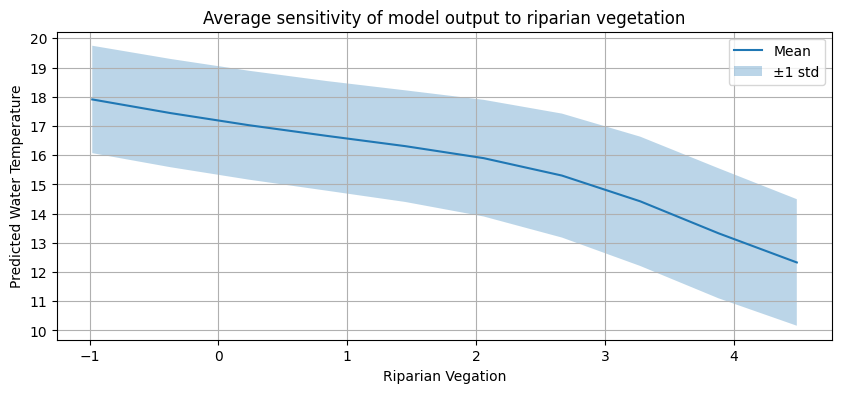

In [55]:
results = analyze_neuron_effect_all(
    model,
    filtered_inputs,
    feature_groups=training.feature_groups,
    feature_name="slavi", 
    n_points=10
)

Split model at layer concatenated_inputs
→ first_half_model output shape: (None, 12)
→ second_half_model input shape: (None, 12)
predicted_features shape: (9435, 12)
Analyzing feature 'Group_temperature' (index 0)


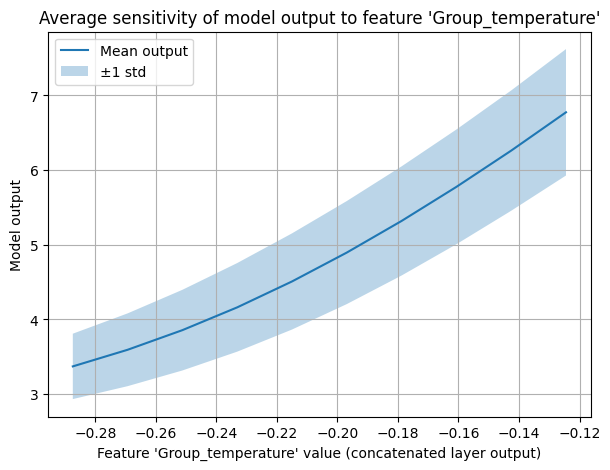

Split model at layer concatenated_inputs
→ first_half_model output shape: (None, 12)
→ second_half_model input shape: (None, 12)
predicted_features shape: (9435, 12)
Analyzing feature 'Group_pressure' (index 1)


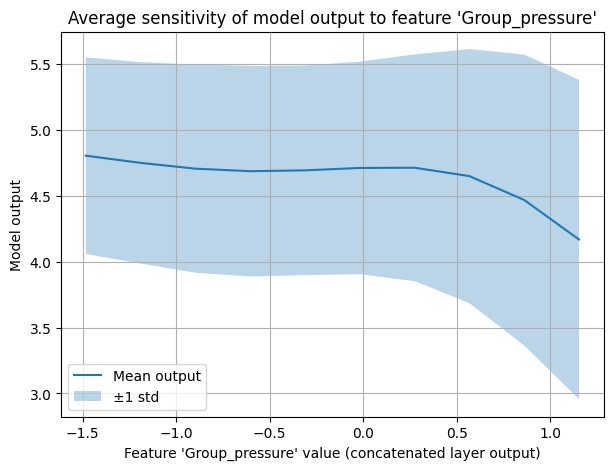

Split model at layer concatenated_inputs
→ first_half_model output shape: (None, 12)
→ second_half_model input shape: (None, 12)
predicted_features shape: (9435, 12)
Analyzing feature 'Group_evaporation' (index 2)


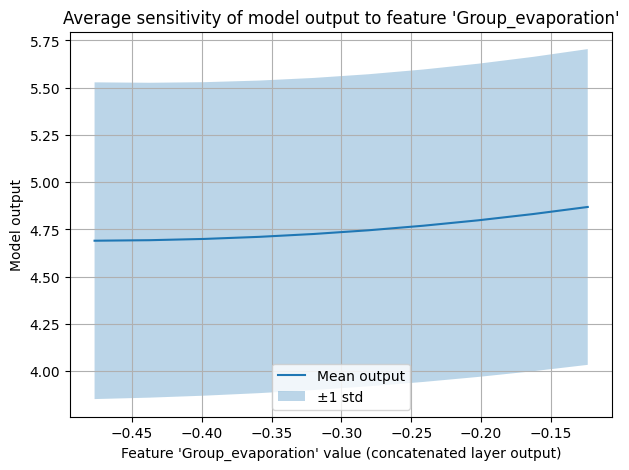

Split model at layer concatenated_inputs
→ first_half_model output shape: (None, 12)
→ second_half_model input shape: (None, 12)
predicted_features shape: (9435, 12)
Analyzing feature 'Group_wind' (index 3)


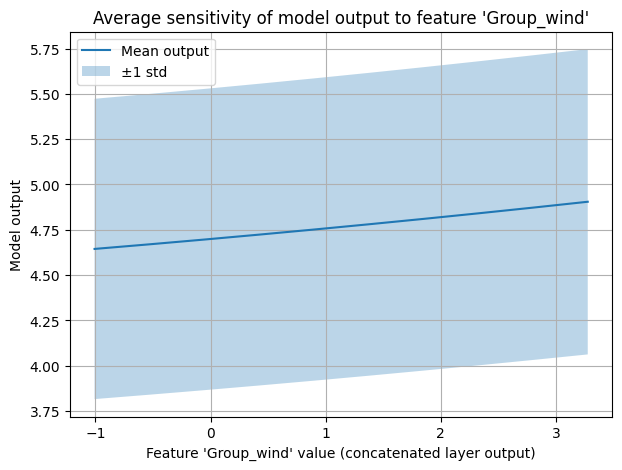

Split model at layer concatenated_inputs
→ first_half_model output shape: (None, 12)
→ second_half_model input shape: (None, 12)
predicted_features shape: (9435, 12)
Analyzing feature 'Group_cloud' (index 4)


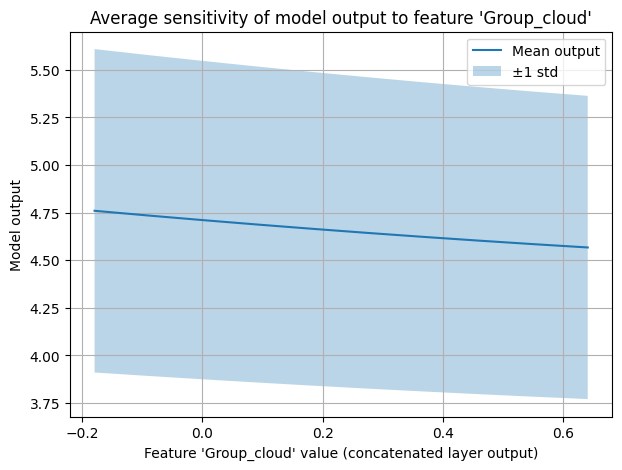

Split model at layer concatenated_inputs
→ first_half_model output shape: (None, 12)
→ second_half_model input shape: (None, 12)
predicted_features shape: (9435, 12)
Analyzing feature 'Group_hydrometeorology' (index 5)


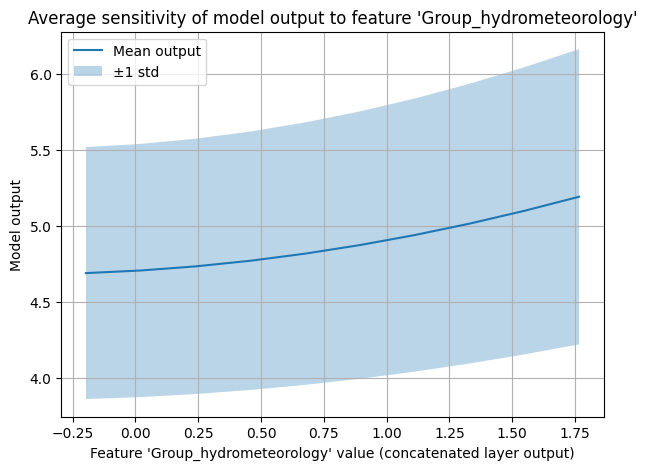

Split model at layer concatenated_inputs
→ first_half_model output shape: (None, 12)
→ second_half_model input shape: (None, 12)
predicted_features shape: (9435, 12)
Analyzing feature 'Group_snow' (index 6)


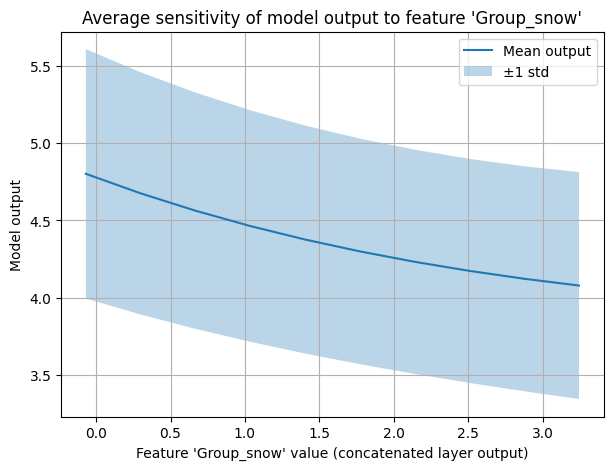

Split model at layer concatenated_inputs
→ first_half_model output shape: (None, 12)
→ second_half_model input shape: (None, 12)
predicted_features shape: (9435, 12)
Analyzing feature 'slavi' (index 7)


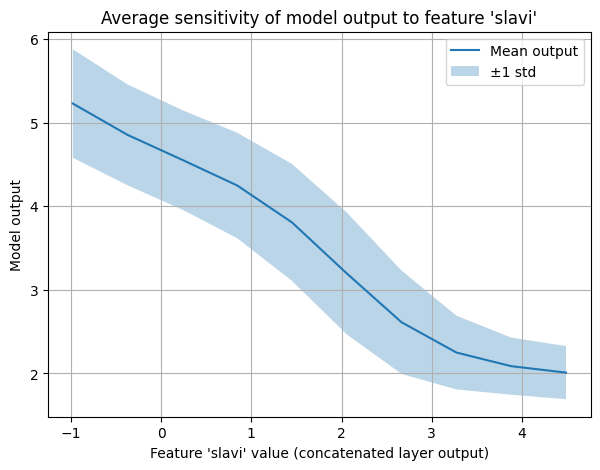

Split model at layer concatenated_inputs
→ first_half_model output shape: (None, 12)
→ second_half_model input shape: (None, 12)
predicted_features shape: (9435, 12)
Analyzing feature 'altitude' (index 8)


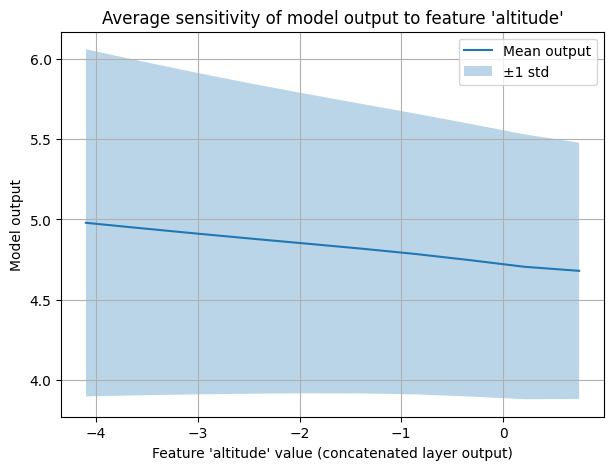

Split model at layer concatenated_inputs
→ first_half_model output shape: (None, 12)
→ second_half_model input shape: (None, 12)
predicted_features shape: (9435, 12)
Analyzing feature 'altitude_difference' (index 9)


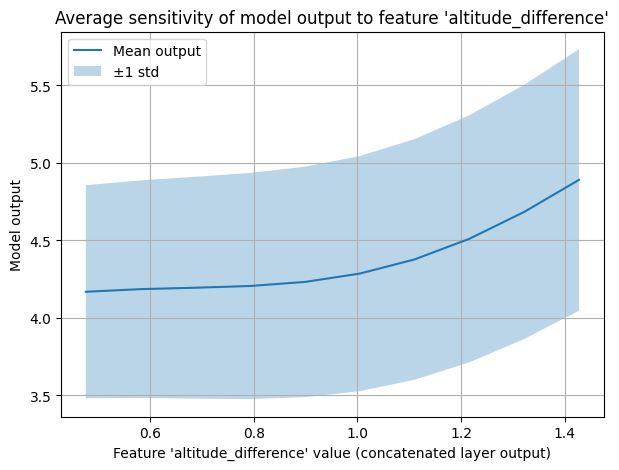

Split model at layer concatenated_inputs
→ first_half_model output shape: (None, 12)
→ second_half_model input shape: (None, 12)
predicted_features shape: (9435, 12)
Analyzing feature 'day_cos' (index 10)


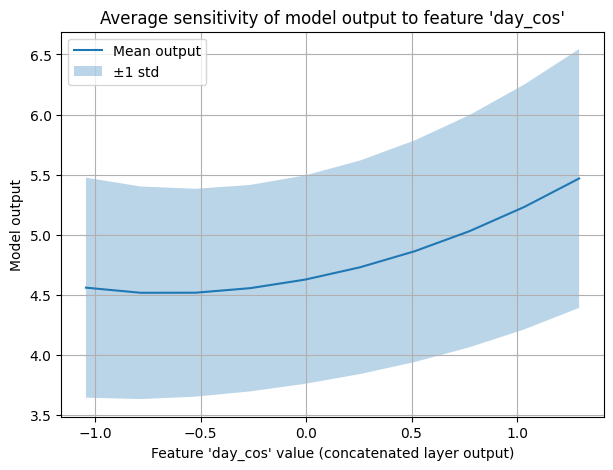

Split model at layer concatenated_inputs
→ first_half_model output shape: (None, 12)
→ second_half_model input shape: (None, 12)
predicted_features shape: (9435, 12)
Analyzing feature 'day_sin' (index 11)


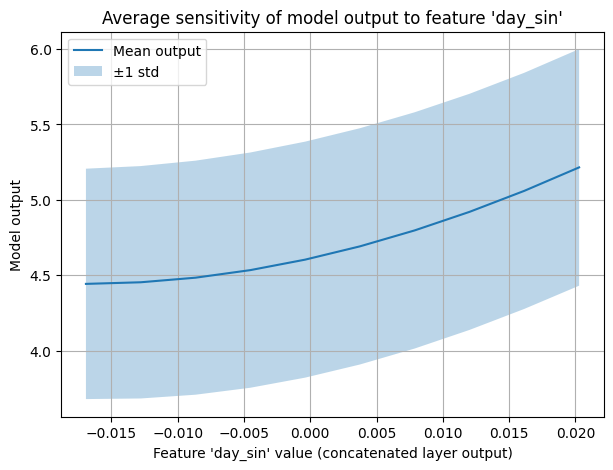

In [36]:
shap_values.feature_names

for this_feature in shap_values.feature_names:
    results = analyze_neuron_effect_all(
        model,
        filtered_inputs,
        feature_groups=training.feature_groups,
        feature_name=this_feature, 
        n_points=10
    )